# Scikit-learn Deployment

In [1]:
!pip install skl2onnx onnxmltools onnxruntime onnxoptimizer

In [2]:
from IPython import display
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [3]:
iris = datasets.load_iris() # Setosa, Versicolour, and Virginica
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [4]:
df["target"].value_counts()

0.0    50
2.0    50
1.0    50
Name: target, dtype: int64

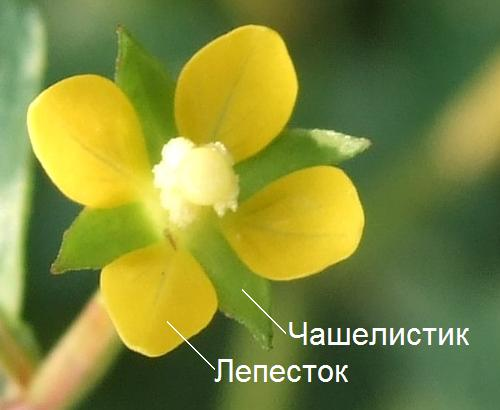

In [5]:
display.Image("./misc/iris.jpeg")

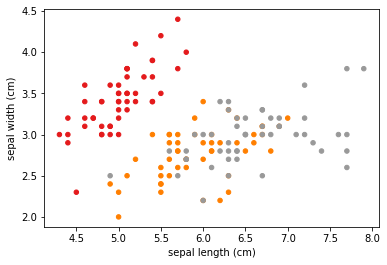

In [6]:
import matplotlib.cm
cmap = matplotlib.cm.get_cmap('Set1')
fig = df.plot.scatter(x="sepal length (cm)", y="sepal width (cm)", c="target", cmap=cmap, colorbar=False)
plt.show()

# Model

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:4], df.iloc[:,-1], test_size=0.3, random_state=142)

In [8]:
model = LogisticRegression()
model.fit(X_train, y_train)
print(f"Train score: {model.score(X_train, y_train)}")
print(f"Test score:  {model.score(X_test, y_test)}")

Train score: 0.9904761904761905
Test score:  0.9333333333333333


In [9]:
model.predict_proba(np.array([[1, 2, 3, 4]]))

array([[0.24249382, 0.08344511, 0.67406108]])

# Model Deployment

The pickle API for serializing standard Python objects.
The joblib API for efficiently serializing Python objects with NumPy arrays.

## Pickle

In [10]:
import pickle

filename = './save/model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [11]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict_proba(np.array([[5.5, 2.6, 2.7, 7.8]]))
print(result)

[[7.27380947e-06 1.74212245e-05 9.99975305e-01]]


## Joblib

In [12]:
import joblib

filename = './save/model.joblib'
joblib.dump(model, filename)

['./save/model.joblib']

In [13]:
loaded_model = joblib.load(filename)
result = loaded_model.predict_proba(np.array([[0.5, 0.6, 0.7, 0.8]]))
print(result)

[[9.95228088e-01 4.77185714e-03 5.48725454e-08]]


# ONNX

In [14]:
import onnxmltools
from skl2onnx.common.data_types import FloatTensorType

filename = './save/model.onnx'
initial_types = [('input', FloatTensorType([1, 4]))]
onnx_model = onnxmltools.convert_sklearn(model, 'Iris Model', initial_types=initial_types)

with open(filename, "wb") as f:
    f.write(onnx_model.SerializeToString())

In [15]:
import onnxruntime as rt

sess = rt.InferenceSession(filename)
print(list(map(lambda x: x.name, sess.get_inputs())))
print(list(map(lambda x: x.name, sess.get_outputs())))

inputs = sess.get_inputs()
outputs = sess.get_outputs()
input_name = inputs[0].name
input_data = {input_name: np.array([[0.5, 0.6, 0.7, 0.8]]).astype(np.float32)}

pred_onx = sess.run([], input_data)
pred_onx

['input']
['output_label', 'output_probability']


[array([0], dtype=int64),
 [{0: 0.9952281713485718, 1: 0.004771856125444174, 2: 5.487248699864722e-08}]]

# ONNX LinearRegression

In [19]:
model = LinearRegression()
model.fit(X_train, y_train)

filename = './save/model_linear.onnx'
initial_types = [('input', FloatTensorType([1, 4]))]
onnx_model = onnxmltools.convert_sklearn(model, 'Iris Model', initial_types=initial_types)

with open(filename, "wb") as f:
    f.write(onnx_model.SerializeToString())